STAT 479: Machine Learning (Fall 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-fs2019/

# L13: Dimensionality Reduction 1 -- Feature Selection

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -p sklearn,mlxtend -v

Sebastian Raschka 2019-11-14 

CPython 3.7.1
IPython 7.9.0

sklearn 0.21.3
mlxtend 0.17.0


<br>
<br>

## Iris Overview

- In practice, it is always a good idea to inspect the data before attempting any predictive modeling
- If the dataset is small, we may be able to tell which features are important just by looking at different visualizations

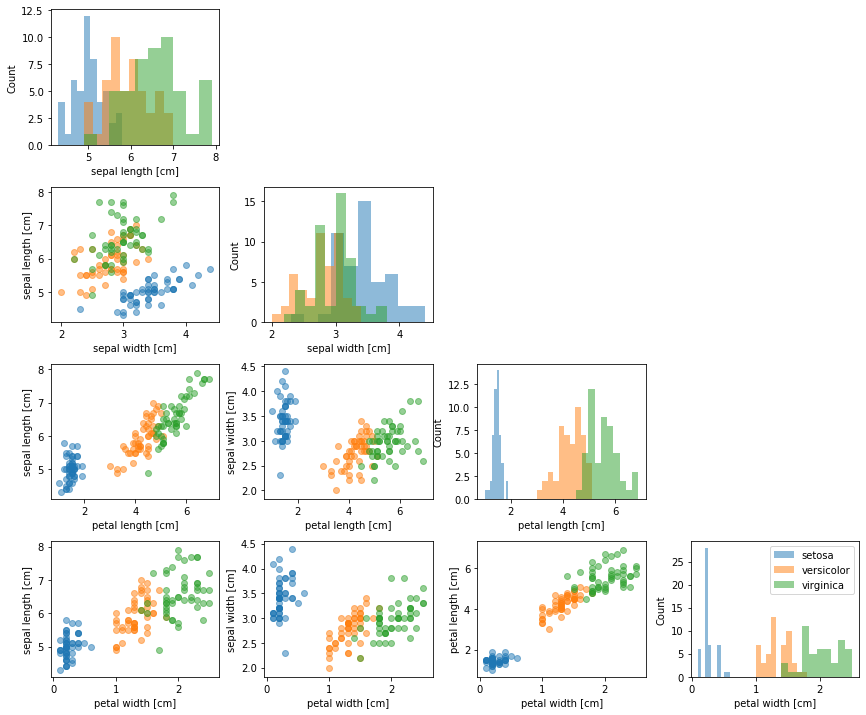

In [23]:
%matplotlib inline
from mlxtend.data import iris_data
from mlxtend.plotting import scatterplotmatrix
import matplotlib.pyplot as plt


X, y = iris_data()


names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X[y==0], figsize=(12, 10), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.legend(['setosa', 'versicolor', 'virginica'])
plt.tight_layout()
plt.show()

- In the case of Iris, we can see that petal length and petal width are more informative then sepal length and sepal width for distinguishing between different flower classes
- However, in many real-world, high dimensional datasets, we cannot intuitively tell which the good features are

<br>
<br>

<br>
<br>

## Feature Importance from Linear Model Coefficients

- When we use generalized linear models, where the prediction is based on a linear relationship between the input features, we can inspect the model coefficients to tell us which features are the biggest contributors for predicting a class (this assumes that the features are all on the same scale!)

- Suppose we have a logistic regression model (a binary classifier)

### Binary Class

![](code-figures/logreg.png)

- First, we fit the classifier to the training data and evaluate it on the test set
- Note that we are only using 2 classes here, Iris-Versicolor and Iris-Virginica

In [24]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X[50:150], y[50:150], test_size=0.3, random_state=1, stratify=y[50:150])


pipe = make_pipeline(StandardScaler(),
                     # params below actually not necessary:
                     LogisticRegression(solver='newton-cg', multi_class='multinomial'))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 96.67%


In [25]:
lr_model = pipe.named_steps.logisticregression
lr_model.coef_

array([[-0.09211828, -0.29927205,  1.27812501,  1.22789905]])

In [26]:
np.abs(lr_model.coef_)

array([[0.09211828, 0.29927205, 1.27812501, 1.22789905]])

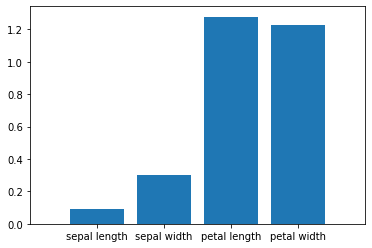

In [27]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), np.abs(lr_model.coef_.flatten()))
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

- Looking at magnitudes of the the model coefficients, we can say that petal length and petal width are the two most important features in the logistic regression model, since they have the most influence on the weighted linear combination of the features

<br>
<br>

<br>
<br>

### Multi-Class

- We can do the same thing for multinomial logistic regression (i.e., softmax regression), which is a model that is a bit more complicated -- it will be covered in more detail in Stat 453: Deep Learning and Generative Models

![](code-figures/multinomial-logreg.png)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


pipe = make_pipeline(StandardScaler(),
                     LogisticRegression(solver='newton-cg', multi_class='multinomial'))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 97.78%


In [8]:
lr_model = pipe.named_steps.logisticregression
lr_model.coef_

array([[-1.05554231,  1.01406239, -1.75805264, -1.60180046],
       [ 0.22718366, -0.26599486, -0.13917565, -0.58186585],
       [ 0.82835866, -0.74806753,  1.89722829,  2.18366631]])

- The difference to binary logistic regression is that in softmax regression, we have more than 2 classes; for each class, we have model coefficients then
- The first row in the array above corresponds to the model coefficients for Iris-Setosa, the second row to the model coefficients of Iris-Versicolor, and the last row to the model coefficients of Iris-Virginica

In [9]:
coefs = np.sum(np.abs(lr_model.coef_), axis=0)
coefs

array([2.11108463, 2.02812478, 3.79445658, 4.36733262])

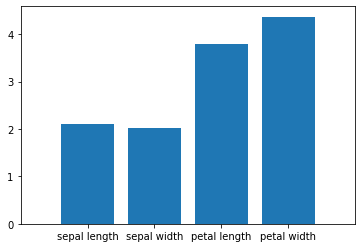

In [10]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), coefs)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

- Again, we can see that for this multi-class setting, the petal length and petal width are the most important features as they correspond to the largest model coefficients

<br>
<br>

<br>
<br>

## Feature Importance via Permutation

- In this section, we are permuting individual features as discussed in class
- I.e., the following function will compute the test set accuracy and then permute each individual feature and assess how much the test accuracy changes when the feature is permuted
- The feature, when it is permuted, that changes the accuracy the most is the most important feature; more details can be found in the documentation that is linked below:

- http://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/

In [11]:
from mlxtend.evaluate import feature_importance_permutation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [13]:
pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(n_neighbors=3))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 95.56%


In [14]:
imp_vals, _ = feature_importance_permutation(
    predict_method=pipe.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=100,
    seed=1)

imp_vals

array([0.03711111, 0.07066667, 0.20488889, 0.31022222])

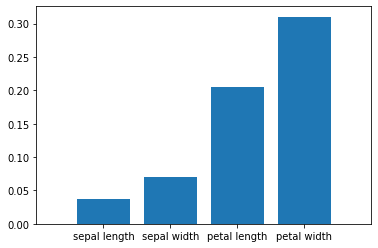

In [15]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), imp_vals)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

## Random Forest Feature Importance

- Random forests also have two special ways for assessing feature importance; in class, we called these "method A" and "method B"
- In scikit-learn, the feature importance is computed via "method A" (see lecture slides for details)

In [16]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=100, random_state=123)
forest.fit(X_train, y_train);

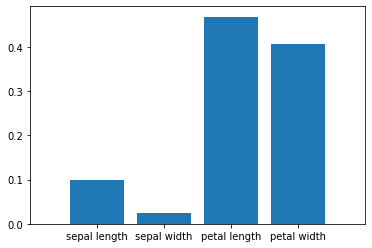

In [17]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), forest.feature_importances_)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

## Sequential Feature Selection

- Lastly, a powerful (yet computationally expensive) approach for computing feature importance is sequential feature selection
- More details of how this works are provided in the MLxtend documentation that can be accessed via the link below

- http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(n_neighbors=5))

sfs1 = SFS(pipe, 
           k_features=4, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished

[2019-11-14 14:39:48] Features: 1/4 -- score: 0.9416666666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2019-11-14 14:39:49] Features: 2/4 -- score: 0.9583333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2019-11-14 14:39:49] Features: 3/4 -- score: 0.9333333333333333[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [19]:
sfs1.subsets_

{1: {'feature_idx': (2,),
  'cv_scores': array([1.        , 0.91666667, 1.        , 0.91666667, 0.91666667,
         1.        , 1.        , 0.88888889, 0.88888889, 0.88888889]),
  'avg_score': 0.9416666666666667,
  'feature_names': ('2',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([1.        , 1.        , 1.        , 1.        , 0.91666667,
         1.        , 0.88888889, 1.        , 0.88888889, 0.88888889]),
  'avg_score': 0.9583333333333334,
  'feature_names': ('2', '3')},
 3: {'feature_idx': (0, 2, 3),
  'cv_scores': array([1.        , 0.91666667, 0.91666667, 0.91666667, 0.91666667,
         1.        , 0.88888889, 1.        , 0.88888889, 0.88888889]),
  'avg_score': 0.9333333333333333,
  'feature_names': ('0', '2', '3')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([1.        , 1.        , 0.91666667, 0.83333333, 0.91666667,
         1.        , 1.        , 0.88888889, 0.88888889, 0.88888889]),
  'avg_score': 0.9333333333333333,
  'feature_names': ('0', '1', '2

In [20]:
import pandas as pd


pd.DataFrame.from_dict(sfs1.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.941667,0.0295001,"[1.0, 0.9166666666666666, 1.0, 0.9166666666666...","(2,)","(2,)",0.0488289,0.0162763
2,0.958333,0.0311713,"[1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, ...","(2, 3)","(2, 3)",0.0515949,0.0171983
3,0.933333,0.0272676,"[1.0, 0.9166666666666666, 0.9166666666666666, ...","(0, 2, 3)","(0, 2, 3)",0.0451335,0.0150445
4,0.933333,0.035362,"[1.0, 1.0, 0.9166666666666666, 0.8333333333333...","(0, 1, 2, 3)","(0, 1, 2, 3)",0.0585314,0.0195105


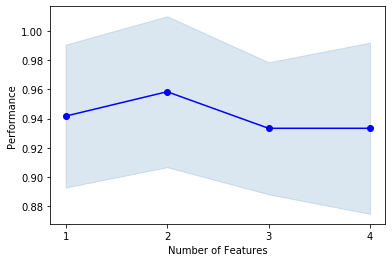

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

### Pipeline

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(),
                     SFS(estimator=KNeighborsClassifier(n_neighbors=5), k_features=2),
                     KNeighborsClassifier(n_neighbors=5))


pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 100.00%
